# Ocean station Papa

This notebook plots the time series of the surface forcing and simulated sea surface temperature, sea surface salinity, and mixed layer depth in the [ocean station Papa](https://www.pmel.noaa.gov/ocs/Papa) case.

In [1]:
import sys
import numpy as np
import string
import matplotlib.pyplot as plt
# add the path of gotmtool
sys.path.append("../gotmtool")
from gotmtool import *
from gotmtool.diags import get_mld_deltaT

## Load data

First, store the information of the four simulations into lists and dictionaries. 

In [2]:
casenames = [
    'GLS-C01A',
    'KPP-CVMix',
    'KPPLT-VR12',
    'KPPLT-LF17',
    ]

colors = {
    'GLS-C01A': 'tab:blue',
    'KPP-CVMix': 'tab:olive',
    'KPPLT-VR12': 'tab:orange',
    'KPPLT-LF17': 'tab:red',
    }

rundates = {
    '2012-03-21': '2012-05-21',
    '2012-05-21': '2012-08-21',
    '2012-08-21': '2013-01-12',
    '2013-01-12': '2013-03-21',
    }

casedir = '../gotm/run/OSPapa'
save_fig = True

Load data for the four simulations and four stages into a dictionary.

In [3]:
sims = {}
dataset = {}
for case in casenames:
    sims0 = {}
    dataset0 = {}
    for start in rundates.keys():
        end = rundates[start]
        sim = Simulation(path=casedir+'/'+case+'_'+start+'_'+end)
        sims0[start] = sim
        dataset0[start] = sim.load_data()
    sims[case] = sims0
    dataset[case] = dataset0

## Figure

Time series of (a) net surface heat flux (W m$^{-2}$), (b) net freshwater flux (precipitation minus evaporation; mg m$^{-2}$ s$^{-1}$), (c) surface friction velocity (m s$^{-1}$), (d) La$_t^{-2}$ where La$_t$ is the turbulent Langmuir number, (e) sea surface temperature (SST; $^\circ$C), (f) sea surface salinity (SSS; g kg$^{-1}$) and (g) mixed layer depth  (MLD; m) defined by a temperature threshold method.

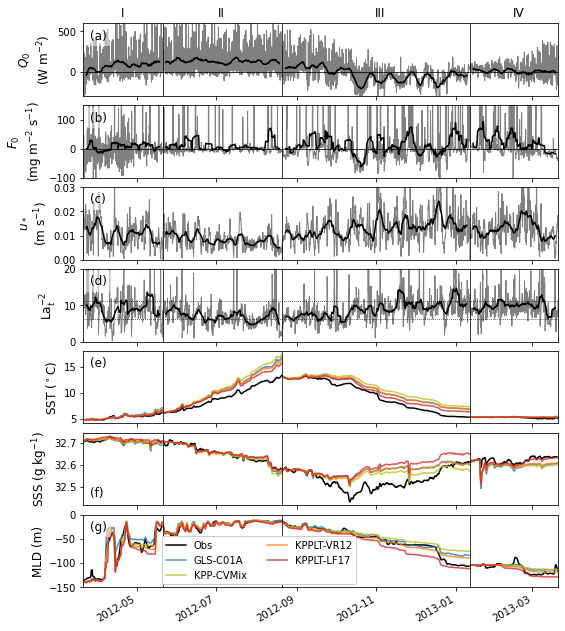

In [4]:
fig, axarr = plt.subplots(7,sharex='col')
fig.set_size_inches([8,9])

rho_w = 1000.
for i, start in enumerate(rundates.keys()):
    data    = dataset['KPP-CVMix'][start]
    ustar   = data.u_taus
    laturb  = data.La_Turb
    laturb  = laturb.where(laturb < 1.e3, drop=True)
    heat    = data.heat
    I0      = data.I_0
    tflux   = heat + I0
    pme     = data.precip * rho_w * 1e6 # m/s -> mg/m^2/s
    
    tflux.plot(ax=axarr[0], color='gray', linewidth=1)
    tflux.rolling(time=40, center=True).mean().plot(
        ax=axarr[0], color='k', linewidth=1.5)
    pme.plot(ax=axarr[1], color='gray', linewidth=1)
    pme.rolling(time=40, center=True).mean().plot(
        ax=axarr[1], color='k', linewidth=1.5)
    ustar.plot(ax=axarr[2], color='gray', linewidth=1)
    ustar.rolling(time=40, center=True).mean().plot(
        ax=axarr[2], color='k', linewidth=1.5)
    (laturb**(-2)).plot(ax=axarr[3], color='gray', linewidth=1)
    (laturb**(-2)).rolling(time=40, center=True).mean().plot(
        ax=axarr[3], color='k', linewidth=1.5)

    if i == 0:
        label = 'Obs'
    else:
        label = None
    sst_obs = data.sst_obs
    sst_obs.rolling(time=8, center=True).mean().plot(
        ax=axarr[4], color='k', linewidth=1.5)
    sss_obs = data.sss
    sss_obs.rolling(time=8, center=True).mean().plot(
        ax=axarr[5], color='k', linewidth=1.5)
    
    mld_obs = -get_mld_deltaT(data.temp_obs[:,:,0,0])
    mld_obs.rolling(time=8, center=True).mean().plot(
        ax=axarr[6], color='k', linewidth=1.5, label=label)
    
    for case in casenames:
        if i == 0:
            label = case
        else:
            label = None
        temp = dataset[case][start].temp
        temp[-1,:,0,0].rolling(time=8, center=True).mean().plot(
            ax=axarr[4], color=colors[case], linewidth=1.5, alpha=0.8)
        
        salt = dataset[case][start].salt
        salt[-1,:,0,0].rolling(time=8, center=True).mean().plot(
            ax=axarr[5], color=colors[case], linewidth=1.5, alpha=0.8)
        
        mld = -get_mld_deltaT(temp[:,:,0,0])
        mld.rolling(time=8, center=True).mean().plot(
            ax=axarr[6], color=colors[case], linewidth=1.5, alpha=0.8, label=label)
        
axarr[6].legend(loc = 'lower center', fontsize=10, ncol=2,
                bbox_to_anchor=(0.37, -0.03), framealpha=1)

axarr[0].set_ylabel('$Q_0$\n(W m$^{-2}$)', fontsize=12)
axarr[0].axhline(0, color='k', linewidth=0.75)
axarr[0].set_ylim([-300, 600])
axarr[1].set_ylabel('$F_0$\n(mg m$^{-2}$ s$^{-1}$)', fontsize=12)
axarr[1].set_ylim([-100, 150])
axarr[1].ticklabel_format(style='sci', axis='y', scilimits=(-3,3))
axarr[1].axhline(0, color='k', linewidth=0.75)
axarr[2].set_ylabel('$u_*$\n(m s$^{-1}$)', fontsize=12)
axarr[2].set_ylim([0, 0.03])
axarr[3].axhline(0.3**(-2), color='k', linestyle=':', linewidth=0.75)
axarr[3].axhline(0.4**(-2), color='k', linestyle=':', linewidth=0.75)
axarr[3].set_ylim([0, 20])
axarr[3].set_ylabel('La$_t^{-2}$', fontsize=12)
axarr[4].set_ylabel('SST ($^\circ$C)', fontsize=12)
axarr[5].set_ylabel('SSS (g kg$^{-1}$)', fontsize=12)
axarr[6].set_ylim([-150, 0])
axarr[6].set_ylabel('MLD (m)', fontsize=12)

startdate = list(rundates.keys())
for i, ax in enumerate(axarr):
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_xlim([np.datetime64('2012-03-21'), np.datetime64('2013-03-21')])
    ax.axvline(np.datetime64(startdate[1]), color='k', linewidth=0.75)
    ax.axvline(np.datetime64(startdate[2]), color='k', linewidth=0.75)
    ax.axvline(np.datetime64(startdate[3]), color='k', linewidth=0.75)
    if i == 5:
        ax.text(0.015, 0.08, '('+string.ascii_lowercase[i]+')', transform=ax.transAxes,
                bbox=dict(facecolor='w', edgecolor='none', alpha=0.5),
                fontsize=12, va='bottom')
    else:
        ax.text(0.015, 0.92, '('+string.ascii_lowercase[i]+')', transform=ax.transAxes,
                bbox=dict(facecolor='w', edgecolor='none', alpha=0.5),
                fontsize=12, va='top')
    
axarr[0].text(0.083, 1.05, 'I', transform=axarr[0].transAxes,
              fontsize=12, va='bottom', ha='center')
axarr[0].text(0.29, 1.05, 'II', transform=axarr[0].transAxes,
              fontsize=12, va='bottom', ha='center')
axarr[0].text(0.625, 1.05, 'III', transform=axarr[0].transAxes,
              fontsize=12, va='bottom', ha='center')
axarr[0].text(0.917, 1.05, 'IV', transform=axarr[0].transAxes,
              fontsize=12, va='bottom', ha='center')

if save_fig:
    plt.subplots_adjust(top=0.95, bottom=0.08, right=0.95, hspace=0.13)
    figname = 'ospapa_ts.pdf'
    fig.savefig(figname, dpi=300)